# Library Installations  


In [1]:
!pip install langchain 
!pip install langchain_community
!pip install huggingface_hub
!pip install sentence_transformers
!pip install langchain
!pip install datasets
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.35
    Uninstalling langchain-core-0.3.35:
      Successfully uninstalled langchain-core-0.3.35
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.6
    Uninstalling langchain-text-splitters-0.3.6:
      Successfully uninstalled langchain-text-splitters-0.3.6
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.18
    Uninstalling langchain-0.3.18:
      Successfully uninstalled langchain-0.3.18
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0

# load data

In [2]:
from datasets import load_dataset

datasets = ["narrativeqa", "qasper", "multifieldqa_en", "multifieldqa_zh", "hotpotqa", "2wikimqa", "musique",
            "dureader", "gov_report", "qmsum", "multi_news", "vcsum", "trec", "triviaqa", "samsum", "lsht",
            "passage_count", "passage_retrieval_en", "passage_retrieval_zh", "lcc", "repobench-p"]


data = load_dataset('THUDM/LongBench', "narrativeqa")


 # LangchainDocument

In [3]:
from tqdm import tqdm
from langchain.docstore.document import Document

RAW_KNOWLEDGE_BASE = [
    Document(
        page_content=doc["context"],
        metadata={
            "question": doc["input"],
            "short_answer": doc["answers"]
        }
    )
    for doc in tqdm(data["test"])  # Iterate over the correct split of the dataset
]


100%|██████████| 200/200 [00:00<00:00, 4415.50it/s]


In [4]:
len(RAW_KNOWLEDGE_BASE)

200

## chunking

In [5]:
import pandas as pd  
import numpy as np  
import re  
import string  
import nltk  
import torch  
import matplotlib.pyplot as plt  
import torch.nn.functional as F  
from sklearn.decomposition import NMF  
from sklearn.cluster import KMeans  
from sklearn.preprocessing import MinMaxScaler  
from sklearn.metrics import silhouette_score, calinski_harabasz_score  
from sentence_transformers import SentenceTransformer, util  
from transformers import AutoTokenizer, AutoModel

2025-04-15 12:20:50.198552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744719650.373269      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744719650.422511      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]




In [8]:
from datasets import load_dataset
from tqdm import tqdm
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Experiment with multiple chunk sizes and overlaps
chunk_sizes = [500, 1000, 2000, 3000]  # Different chunk sizes to test
chunk_overlaps = [0, 100, 200]        # Different overlaps to test
chunk_counts = {}                     # Store number of chunks for each (size, overlap)

for size in chunk_sizes:
    for overlap in chunk_overlaps:
        if overlap >= size:
            continue
        
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=size,
            chunk_overlap=overlap,
            add_start_index=True,
            strip_whitespace=True,
            separators=MARKDOWN_SEPARATORS,
        )
        
        docs_processed = []
        for doc in tqdm(RAW_KNOWLEDGE_BASE, desc=f"Chunking size={size}, overlap={overlap}"):
            docs_processed += text_splitter.split_documents([doc])
        
        # Store the number of chunks
        chunk_counts[(size, overlap)] = len(docs_processed)




Chunking size=3000, overlap=200: 100%|██████████| 200/200 [00:00<00:00, 452.26it/s]


In [9]:
sizes = sorted(set(size for size, _ in chunk_counts.keys()))
overlaps = sorted(set(overlap for _, overlap in chunk_counts.keys()))
heatmap_data = np.zeros((len(sizes), len(overlaps)))

for i, size in enumerate(sizes):
    for j, overlap in enumerate(overlaps):
        if (size, overlap) in chunk_counts:
            heatmap_data[i, j] = chunk_counts[(size, overlap)]



##  Create heatmap


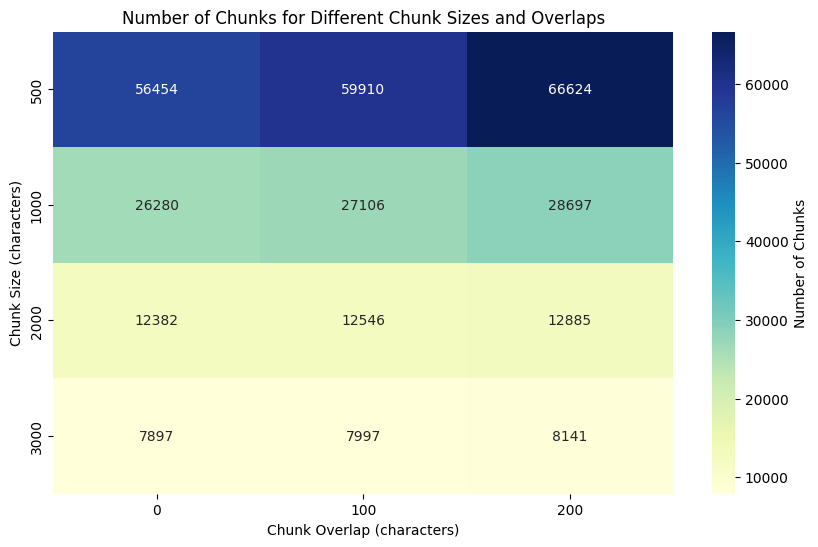

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    xticklabels=overlaps,
    yticklabels=sizes,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    cbar_kws={"label": "Number of Chunks"}
)
plt.title("Number of Chunks for Different Chunk Sizes and Overlaps")
plt.xlabel("Chunk Overlap (characters)")
plt.ylabel("Chunk Size (characters)")
plt.show()